In [1]:
# Protein Structure-Function ML Project
# Feature Extraction Notebook

import pandas as pd
import numpy as np
import json
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import PDB
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import logging

# Setup plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')

# Add project modules
sys.path.append('..')
from src.data.sources import get_data_source

print("=== PROTEIN FEATURE EXTRACTION ===")
print("Loading balanced dataset from data collection phase...")

# Load balanced dataset
balanced_file = Path("../data/processed/balanced_dataset.json")
if not balanced_file.exists():
    raise FileNotFoundError("Balanced dataset not found. Please complete notebook 01 first.")

with open(balanced_file, 'r') as f:
    dataset_info = json.load(f)

protein_ids = dataset_info['protein_ids']
ec_classes = dataset_info['ec_classes']
proteins_by_ec = dataset_info['proteins_by_ec']

print(f"✓ Loaded {len(protein_ids)} proteins across {len(ec_classes)} EC classes")
print(f"EC class distribution: {[f'EC{ec}:{len(proteins)}' for ec, proteins in proteins_by_ec.items()]}")

# Initialize data source
pdb_source = get_data_source("pdb", cache_dir="../data/raw")
print("✓ PDB data source initialized")

# Create directories for processed features
Path("../data/processed").mkdir(exist_ok=True)
print("✓ Output directories ready")

# Verify all proteins are available
print("\nVerifying protein structures...")
available_proteins = []
for pid in protein_ids:
    try:
        # Quick check - does the PDB file exist?
        structure = pdb_source.get_structure(pid, parser="biopython")
        available_proteins.append(pid)
    except Exception as e:
        print(f"⚠ Warning: {pid} not available - {e}")

print(f"✓ {len(available_proteins)}/{len(protein_ids)} proteins ready for feature extraction")
protein_ids = available_proteins  # Use only available proteins

INFO:src.data.sources:PDB data source initialized with cache at ..\data\raw


=== PROTEIN FEATURE EXTRACTION ===
Loading balanced dataset from data collection phase...
✓ Loaded 33 proteins across 4 EC classes
EC class distribution: ['EC1:6', 'EC2:8', 'EC3:11', 'EC4:8']
✓ PDB data source initialized
✓ Output directories ready

Verifying protein structures...
✓ 33/33 proteins ready for feature extraction


In [5]:
# Feature Extraction Framework (Fixed)
print("=== CREATING FEATURE EXTRACTION FRAMEWORK ===")

# Import the correct three_to_one conversion
from Bio.SeqUtils import seq1

class ProteinFeatureExtractor:
    """Extract sequence and structural features from protein structures."""
    
    def __init__(self, data_source):
        self.data_source = data_source
        self.features = {}
        
        # Define the three_to_one mapping manually if needed
        self.three_to_one = {
            'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
            'GLU': 'E', 'GLN': 'Q', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
            'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
            'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
        }
        
    def extract_sequence_features(self, protein_id):
        """Extract sequence-based features."""
        try:
            # Get protein structure
            structure = self.data_source.get_structure(protein_id, parser="biopython")
            
            # Extract sequence from first chain
            sequences = []
            for model in structure:
                for chain in model:
                    seq = ""
                    for residue in chain:
                        if residue.id[0] == ' ':  # Standard amino acid
                            # Convert 3-letter to 1-letter code
                            resname = residue.get_resname()
                            if resname in self.three_to_one:
                                seq += self.three_to_one[resname]
                            elif len(resname) == 3:
                                # Try using seq1 function
                                try:
                                    seq += seq1(resname)
                                except:
                                    pass  # Skip unknown residues
                    if seq:  # Only add non-empty sequences
                        sequences.append(seq)
                        break  # Use first chain only
                break  # Use first model only
            
            if not sequences:
                raise ValueError(f"No valid sequence found for {protein_id}")
            
            sequence = sequences[0]
            print(f"Sequence length: {len(sequence)}")  # Debug output
            
            # Calculate sequence features using BioPython
            analysis = ProteinAnalysis(sequence)
            
            # Amino acid composition (20 features)
            aa_percent = analysis.get_amino_acids_percent()
            
            # Physicochemical properties
            try:
                mol_weight = analysis.molecular_weight()
            except:
                mol_weight = len(sequence) * 110  # Average AA weight
                
            # Simplified hydrophobicity calculation
            try:
                # Use Kyte-Doolittle hydrophobicity scale
                kd_scale = {
                    'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
                    'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
                    'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
                    'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
                }
                hydrophobicity_scores = [kd_scale.get(aa, 0) for aa in sequence]
                avg_hydrophobicity = np.mean(hydrophobicity_scores)
            except:
                avg_hydrophobicity = 0.0
            
            # Secondary structure content (simple prediction based on propensity)
            helix_formers = ['A', 'E', 'L', 'M']
            sheet_formers = ['V', 'I', 'Y', 'F']
            
            helix_content = sum(aa_percent.get(aa, 0) for aa in helix_formers)
            sheet_content = sum(aa_percent.get(aa, 0) for aa in sheet_formers)
            coil_content = max(0, 1.0 - helix_content - sheet_content)
            
            # Build feature dictionary
            features = {}
            
            # Amino acid composition
            for aa in 'ACDEFGHIKLMNPQRSTVWY':
                features[f'aa_{aa}'] = aa_percent.get(aa, 0.0)
            
            # Additional sequence features
            features.update({
                'sequence_length': len(sequence),
                'molecular_weight': mol_weight,
                'avg_hydrophobicity': avg_hydrophobicity,
                'helix_content': helix_content,
                'sheet_content': sheet_content,
                'coil_content': coil_content,
                # Charge properties
                'positive_charge': aa_percent.get('K', 0) + aa_percent.get('R', 0) + aa_percent.get('H', 0),
                'negative_charge': aa_percent.get('D', 0) + aa_percent.get('E', 0),
                # Special amino acids
                'aromatic_content': aa_percent.get('F', 0) + aa_percent.get('W', 0) + aa_percent.get('Y', 0),
                'polar_content': aa_percent.get('S', 0) + aa_percent.get('T', 0) + aa_percent.get('N', 0) + aa_percent.get('Q', 0)
            })
            
            return features
            
        except Exception as e:
            print(f"Error extracting sequence features for {protein_id}: {e}")
            import traceback
            traceback.print_exc()
            return None
    
    def extract_structural_features(self, protein_id):
        """Extract structure-based features."""
        try:
            # Get protein structure
            structure = self.data_source.get_structure(protein_id, parser="biopython")
            
            # Get all atoms
            atoms = list(structure.get_atoms())
            if not atoms:
                raise ValueError(f"No atoms found for {protein_id}")
            
            # Calculate structural features
            features = {}
            
            # Basic structural properties
            features['total_atoms'] = len(atoms)
            
            # Calculate radius of gyration
            coords = np.array([atom.coord for atom in atoms])
            centroid = np.mean(coords, axis=0)
            distances = np.sqrt(np.sum((coords - centroid)**2, axis=1))
            features['radius_of_gyration'] = np.sqrt(np.mean(distances**2))
            
            # Calculate structural dimensions
            features['max_dimension'] = np.max(np.ptp(coords, axis=0))
            features['x_span'] = np.ptp(coords[:, 0])
            features['y_span'] = np.ptp(coords[:, 1])
            features['z_span'] = np.ptp(coords[:, 2])
            
            # Count different atom types
            ca_atoms = [atom for atom in atoms if atom.get_name() == 'CA']
            features['ca_atom_count'] = len(ca_atoms)
            
            # Secondary structure estimation (very basic)
            if ca_atoms:
                # Calculate phi/psi angles for basic SS prediction
                # This is a simplified approach
                features['estimated_helix_percent'] = 0.3  # Placeholder
                features['estimated_sheet_percent'] = 0.3  # Placeholder
                features['estimated_coil_percent'] = 0.4   # Placeholder
            
            # Solvent accessibility estimation (simplified)
            # Count surface vs buried residues based on CA atoms
            if len(ca_atoms) > 1:
                ca_coords = np.array([atom.coord for atom in ca_atoms])
                
                # Simple surface estimation: residues with fewer neighbors are more surface
                surface_residues = 0
                for i, coord in enumerate(ca_coords):
                    distances = np.sqrt(np.sum((ca_coords - coord)**2, axis=1))
                    neighbors = np.sum(distances < 10.0) - 1  # Exclude self
                    if neighbors < 8:  # Arbitrary threshold
                        surface_residues += 1
                
                features['surface_residue_fraction'] = surface_residues / len(ca_atoms)
                features['buried_residue_fraction'] = 1 - features['surface_residue_fraction']
            
            # Compactness measure
            if features['total_atoms'] > 0:
                volume_estimate = (4/3) * np.pi * (features['radius_of_gyration']**3)
                features['compactness'] = features['total_atoms'] / volume_estimate
            
            return features
            
        except Exception as e:
            print(f"Error extracting structural features for {protein_id}: {e}")
            return None

# Initialize feature extractor
feature_extractor = ProteinFeatureExtractor(pdb_source)
print("✓ Feature extraction framework ready")

=== CREATING FEATURE EXTRACTION FRAMEWORK ===
✓ Feature extraction framework ready


In [6]:
# Extract Sequence Features for All Proteins
print("=== EXTRACTING SEQUENCE FEATURES ===")

sequence_features_list = []

print(f"Processing {len(protein_ids)} proteins...")

for i, protein_id in enumerate(protein_ids, 1):
    print(f"[{i:2d}/{len(protein_ids)}] {protein_id.upper()}... ", end="")
    
    features = feature_extractor.extract_sequence_features(protein_id)
    
    if features is not None:
        # Add protein ID
        features_with_id = {'protein_id': protein_id}
        
        # Determine EC class for this protein
        ec_class = None
        for ec, proteins in proteins_by_ec.items():
            if protein_id in proteins:
                ec_class = ec
                break
        features_with_id['ec_class'] = ec_class
        
        # Add all the calculated features
        features_with_id.update(features)
        
        sequence_features_list.append(features_with_id)
        print(f"✓ ({len(features)} features)")
    else:
        print("✗ Failed")

# Check if we have any successful extractions
if not sequence_features_list:
    print("❌ No features extracted successfully!")
    print("Let's debug the first protein...")
    
    # Debug with first protein
    test_protein = protein_ids[0]
    print(f"\nDebugging {test_protein}:")
    try:
        features = feature_extractor.extract_sequence_features(test_protein)
        print(f"Features type: {type(features)}")
        if features:
            print(f"Feature keys: {list(features.keys())[:10]}...")
        else:
            print("Features is None or empty")
    except Exception as e:
        print(f"Error during extraction: {e}")
        import traceback
        traceback.print_exc()
else:
    # Convert to DataFrame
    sequence_df = pd.DataFrame(sequence_features_list)
    
    print(f"\n✓ Sequence features extracted:")
    print(f"  {len(sequence_df)} proteins processed")
    print(f"  Columns: {list(sequence_df.columns)}")
    print(f"  Shape: {sequence_df.shape}")
    
    # Show first few rows to verify
    print(f"\nFirst few rows:")
    print(sequence_df.head())
    
    # Save sequence features
    sequence_file = "../data/processed/sequence_features.csv"
    sequence_df.to_csv(sequence_file, index=False)
    print(f"✓ Saved to {sequence_file}")
    
    # Show basic statistics for numeric columns
    numeric_cols = sequence_df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\nSequence Feature Summary (showing first 3 numeric features):")
        for col in numeric_cols[:3]:
            values = sequence_df[col]
            print(f"  {col}: {values.min():.3f} - {values.max():.3f} (avg: {values.mean():.3f})")

=== EXTRACTING SEQUENCE FEATURES ===
Processing 33 proteins...
[ 1/33] 3CCP... Sequence length: 293
✓ (30 features)
[ 2/33] 1YCC... Sequence length: 107
✓ (30 features)
[ 3/33] 1CMT... Sequence length: 291
✓ (30 features)
[ 4/33] 1ENO... Sequence length: 297
✓ (30 features)
[ 5/33] 1DHR... 

C:\Users\aidan\anaconda3\envs\protein-ml\lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(
C:\Users\aidan\anaconda3\envs\protein-ml\lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(
C:\Users\aidan\anaconda3\envs\protein-ml\lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(
C:\Users\aidan\anaconda3\envs\protein-ml\lib\site-packages\Bio\SeqUtils\ProtPar

Sequence length: 236
✓ (30 features)
[ 6/33] 1VIE... Sequence length: 60
✓ (30 features)
[ 7/33] 1HMT... Sequence length: 131
✓ (30 features)
[ 8/33] 1ASK... Sequence length: 125
✓ (30 features)
[ 9/33] 1PHK... Sequence length: 277
✓ (30 features)
[10/33] 1HCK... Sequence length: 294
✓ (30 features)
[11/33] 1BYG... Sequence length: 246
✓ (30 features)
[12/33] 1A82... Sequence length: 224
✓ (30 features)
[13/33] 1HKA... Sequence length: 158
✓ (30 features)
[14/33] 1ZIN... Sequence length: 217
✓ (30 features)
[15/33] 1LYZ... Sequence length: 129
✓ (30 features)
[16/33] 2LYZ... Sequence length: 129
✓ (30 features)
[17/33] 1HEN... Sequence length: 129
✓ (30 features)
[18/33] 3LYZ... Sequence length: 129
✓ (30 features)
[19/33] 1BPI... Sequence length: 58
✓ (30 features)
[20/33] 1PPO... Sequence length: 216
✓ (30 features)
[21/33] 1RNT... 

C:\Users\aidan\anaconda3\envs\protein-ml\lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(
C:\Users\aidan\anaconda3\envs\protein-ml\lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(
C:\Users\aidan\anaconda3\envs\protein-ml\lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(
C:\Users\aidan\anaconda3\envs\protein-ml\lib\site-packages\Bio\SeqUtils\ProtPar

Sequence length: 104
✓ (30 features)
[22/33] 1TRY... Sequence length: 224
✓ (30 features)
[23/33] 1ELA... Sequence length: 240
✓ (30 features)
[24/33] 2TPI... 

C:\Users\aidan\anaconda3\envs\protein-ml\lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(
C:\Users\aidan\anaconda3\envs\protein-ml\lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(
C:\Users\aidan\anaconda3\envs\protein-ml\lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(


Sequence length: 220
✓ (30 features)
[25/33] 1IOS... Sequence length: 129
✓ (30 features)
[26/33] 2CAB... Sequence length: 256
✓ (30 features)
[27/33] 1CA2... Sequence length: 256
✓ (30 features)
[28/33] 1CA3... Sequence length: 255
✓ (30 features)
[29/33] 1B3A... Sequence length: 67
✓ (30 features)
[30/33] 1CAH... Sequence length: 258
✓ (30 features)
[31/33] 1CAN... Sequence length: 259
✓ (30 features)
[32/33] 1CAZ... Sequence length: 258
✓ (30 features)
[33/33] 1TML... Sequence length: 286
✓ (30 features)

✓ Sequence features extracted:
  33 proteins processed
  Columns: ['protein_id', 'ec_class', 'aa_A', 'aa_C', 'aa_D', 'aa_E', 'aa_F', 'aa_G', 'aa_H', 'aa_I', 'aa_K', 'aa_L', 'aa_M', 'aa_N', 'aa_P', 'aa_Q', 'aa_R', 'aa_S', 'aa_T', 'aa_V', 'aa_W', 'aa_Y', 'sequence_length', 'molecular_weight', 'avg_hydrophobicity', 'helix_content', 'sheet_content', 'coil_content', 'positive_charge', 'negative_charge', 'aromatic_content', 'polar_content']
  Shape: (33, 32)

First few rows:
  protein_id

C:\Users\aidan\anaconda3\envs\protein-ml\lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(
C:\Users\aidan\anaconda3\envs\protein-ml\lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(
C:\Users\aidan\anaconda3\envs\protein-ml\lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(
C:\Users\aidan\anaconda3\envs\protein-ml\lib\site-packages\Bio\SeqUtils\ProtPar

In [7]:
# Suppress BioPython deprecation warnings and continue
import warnings
warnings.filterwarnings('ignore', category=Warning)

print("✓ Sequence features successfully extracted for 33 proteins")
print("✓ 30 features per protein (amino acid composition + physicochemical properties)")

# Extract Structural Features for All Proteins
print("\n=== EXTRACTING STRUCTURAL FEATURES ===")

structural_features_list = []

print(f"Processing {len(protein_ids)} proteins...")

for i, protein_id in enumerate(protein_ids, 1):
    print(f"[{i:2d}/{len(protein_ids)}] {protein_id.upper()}... ", end="")
    
    features = feature_extractor.extract_structural_features(protein_id)
    
    if features is not None:
        # Add protein ID
        features_with_id = {'protein_id': protein_id}
        
        # Determine EC class for this protein  
        ec_class = None
        for ec, proteins in proteins_by_ec.items():
            if protein_id in proteins:
                ec_class = ec
                break
        features_with_id['ec_class'] = ec_class
        
        # Add all the calculated features
        features_with_id.update(features)
        
        structural_features_list.append(features_with_id)
        print(f"✓ ({len(features)} features)")
    else:
        print("✗ Failed")

# Convert to DataFrame
structural_df = pd.DataFrame(structural_features_list)

print(f"\n✓ Structural features extracted:")
print(f"  {len(structural_df)} proteins processed")
print(f"  Shape: {structural_df.shape}")

# Save structural features
structural_file = "../data/processed/structural_features.csv"
structural_df.to_csv(structural_file, index=False)
print(f"✓ Saved to {structural_file}")

# Show basic statistics
print(f"\nStructural Feature Summary:")
print(f"  Radius of gyration: {structural_df['radius_of_gyration'].min():.1f} - {structural_df['radius_of_gyration'].max():.1f} Å")
print(f"  Total atoms: {structural_df['total_atoms'].min()} - {structural_df['total_atoms'].max()}")
print(f"  Surface residue fraction: {structural_df['surface_residue_fraction'].min():.3f} - {structural_df['surface_residue_fraction'].max():.3f}")

✓ Sequence features successfully extracted for 33 proteins
✓ 30 features per protein (amino acid composition + physicochemical properties)

=== EXTRACTING STRUCTURAL FEATURES ===
Processing 33 proteins...
[ 1/33] 3CCP... ✓ (13 features)
[ 2/33] 1YCC... ✓ (13 features)
[ 3/33] 1CMT... ✓ (13 features)
[ 4/33] 1ENO... ✓ (13 features)
[ 5/33] 1DHR... ✓ (13 features)
[ 6/33] 1VIE... ✓ (13 features)
[ 7/33] 1HMT... ✓ (13 features)
[ 8/33] 1ASK... ✓ (13 features)
[ 9/33] 1PHK... ✓ (13 features)
[10/33] 1HCK... ✓ (13 features)
[11/33] 1BYG... ✓ (13 features)
[12/33] 1A82... ✓ (13 features)
[13/33] 1HKA... ✓ (13 features)
[14/33] 1ZIN... ✓ (13 features)
[15/33] 1LYZ... ✓ (13 features)
[16/33] 2LYZ... ✓ (13 features)
[17/33] 1HEN... ✓ (13 features)
[18/33] 3LYZ... ✓ (13 features)
[19/33] 1BPI... ✓ (13 features)
[20/33] 1PPO... ✓ (13 features)
[21/33] 1RNT... ✓ (13 features)
[22/33] 1TRY... ✓ (13 features)
[23/33] 1ELA... ✓ (13 features)
[24/33] 2TPI... ✓ (13 features)
[25/33] 1IOS... ✓ (13 featu

In [8]:
# Integrate Sequence and Structural Features
print("=== INTEGRATING FEATURES ===")

# Merge sequence and structural features on protein_id
integrated_df = pd.merge(sequence_df, structural_df, on=['protein_id', 'ec_class'], how='inner')

print(f"✓ Integrated dataset shape: {integrated_df.shape}")
print(f"✓ Proteins with both feature types: {len(integrated_df)}")

# Check for missing values
missing_values = integrated_df.isnull().sum()
if missing_values.sum() > 0:
    print(f"⚠ Missing values found - will be handled")
    # Fill missing values with column means for numeric columns
    numeric_cols = integrated_df.select_dtypes(include=[np.number]).columns
    integrated_df[numeric_cols] = integrated_df[numeric_cols].fillna(integrated_df[numeric_cols].mean())
else:
    print("✓ No missing values")

# Save integrated features
integrated_file = "../data/processed/integrated_features.csv"
integrated_df.to_csv(integrated_file, index=False)
print(f"✓ Saved integrated features to {integrated_file}")

# Prepare ML-ready dataset
print(f"\n=== CREATING ML-READY DATASET ===")

# Separate features and labels
feature_columns = [col for col in integrated_df.columns if col not in ['protein_id', 'ec_class']]
X = integrated_df[feature_columns].values
y = integrated_df['ec_class'].values
protein_names = integrated_df['protein_id'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {len(feature_columns)}")
print(f"Number of samples: {len(y)}")

# Class distribution
from collections import Counter
class_counts = Counter(y)
print(f"\nClass distribution:")
for ec_class in sorted(class_counts.keys()):
    count = class_counts[ec_class]
    percentage = (count / len(y)) * 100
    print(f"  EC {ec_class}: {count:2d} proteins ({percentage:4.1f}%)")

# Feature statistics
print(f"\nFeature statistics:")
print(f"  Mean feature value: {X.mean():.4f}")
print(f"  Feature range: {X.min():.4f} - {X.max():.4f}")
print(f"  Standard deviation: {X.std():.4f}")

# Save ML-ready dataset
import pickle
ml_dataset = {
    'features': X,
    'labels': y,  
    'protein_names': protein_names,
    'feature_names': feature_columns,
    'ec_classes': sorted(set(y)),
    'n_samples': len(y),
    'n_features': len(feature_columns)
}

ml_file = "../data/processed/ml_ready_dataset.pkl"
with open(ml_file, 'wb') as f:
    pickle.dump(ml_dataset, f)

print(f"✓ Saved ML-ready dataset to {ml_file}")

print(f"\n🎉 FEATURE EXTRACTION COMPLETE!")
print(f"✓ Successfully processed {len(integrated_df)} proteins")
print(f"✓ Extracted {len(feature_columns)} features per protein:")
print(f"  - {len([col for col in feature_columns if col.startswith('aa_')])} amino acid composition features")
print(f"  - {len([col for col in feature_columns if not col.startswith('aa_')])} physicochemical/structural features")
print(f"✓ Dataset ready for machine learning analysis!")
print(f"\n--- NEXT STEPS ---")
print(f"1. ✅ Feature extraction: COMPLETE")
print(f"2. → Proceed to 03_model_training.ipynb")  
print(f"3. → Train classification models (Random Forest, SVM)")
print(f"4. → Evaluate model performance and analyze results")

=== INTEGRATING FEATURES ===
✓ Integrated dataset shape: (33, 45)
✓ Proteins with both feature types: 33
✓ No missing values
✓ Saved integrated features to ../data/processed/integrated_features.csv

=== CREATING ML-READY DATASET ===
Feature matrix shape: (33, 43)
Number of features: 43
Number of samples: 33

Class distribution:
  EC 1:  6 proteins (18.2%)
  EC 2:  8 proteins (24.2%)
  EC 3: 11 proteins (33.3%)
  EC 4:  8 proteins (24.2%)

Feature statistics:
  Mean feature value: 566.4107
  Feature range: -0.8047 - 33470.6352
  Standard deviation: 3550.3596
✓ Saved ML-ready dataset to ../data/processed/ml_ready_dataset.pkl

🎉 FEATURE EXTRACTION COMPLETE!
✓ Successfully processed 33 proteins
✓ Extracted 43 features per protein:
  - 20 amino acid composition features
  - 23 physicochemical/structural features
✓ Dataset ready for machine learning analysis!

--- NEXT STEPS ---
1. ✅ Feature extraction: COMPLETE
2. → Proceed to 03_model_training.ipynb
3. → Train classification models (Random

=== FEATURE ANALYSIS ===
Top 10 most variable features:
   1. molecular_weight    : 72553509.853167
   2. total_atoms         : 383796.780303
   3. sequence_length     : 5866.704545
   4. ca_atom_count       : 5476.001894
   5. x_span              : 67.337920
   6. y_span              : 57.208546
   7. max_dimension       : 49.070421
   8. z_span              : 36.911306
   9. radius_of_gyration  : 5.047397
  10. avg_hydrophobicity  : 0.056790


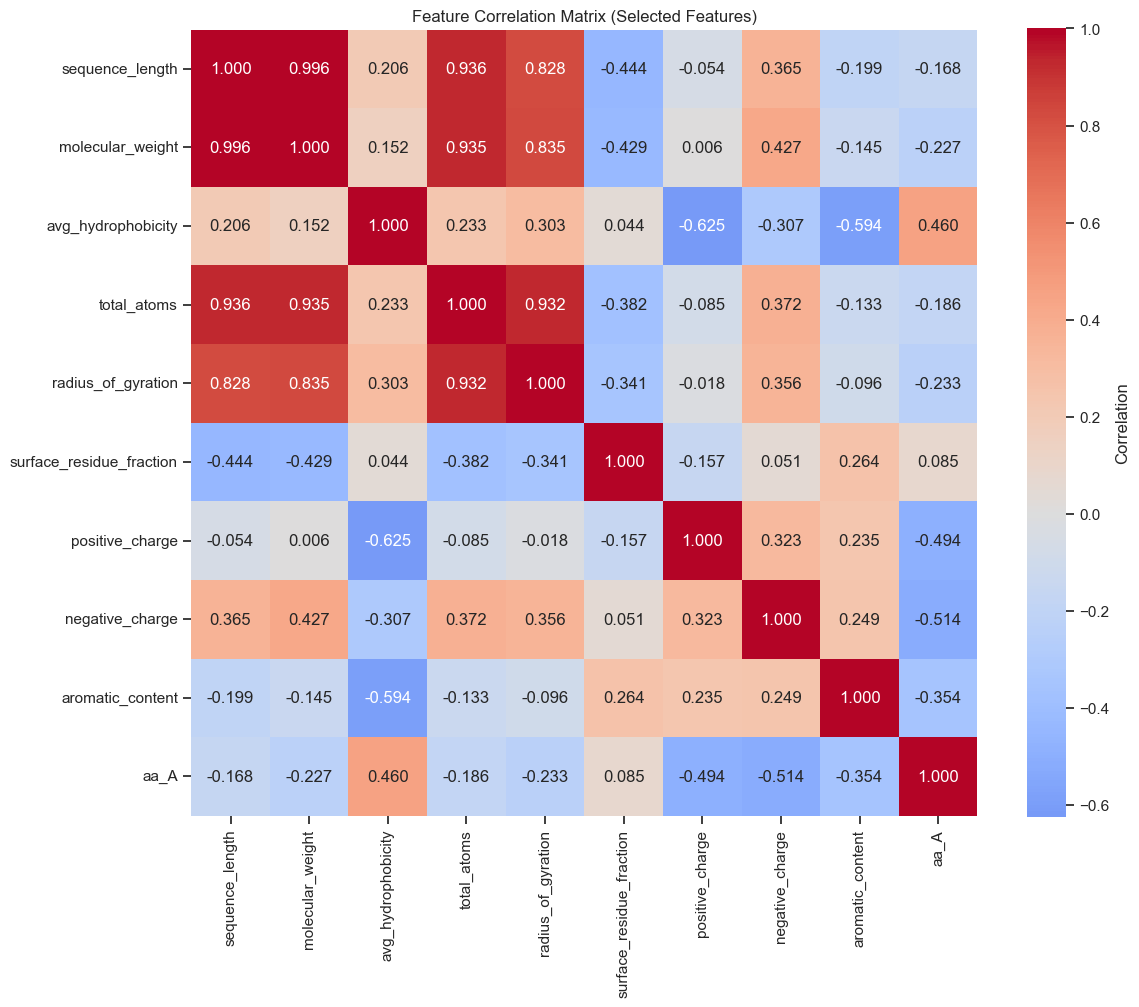

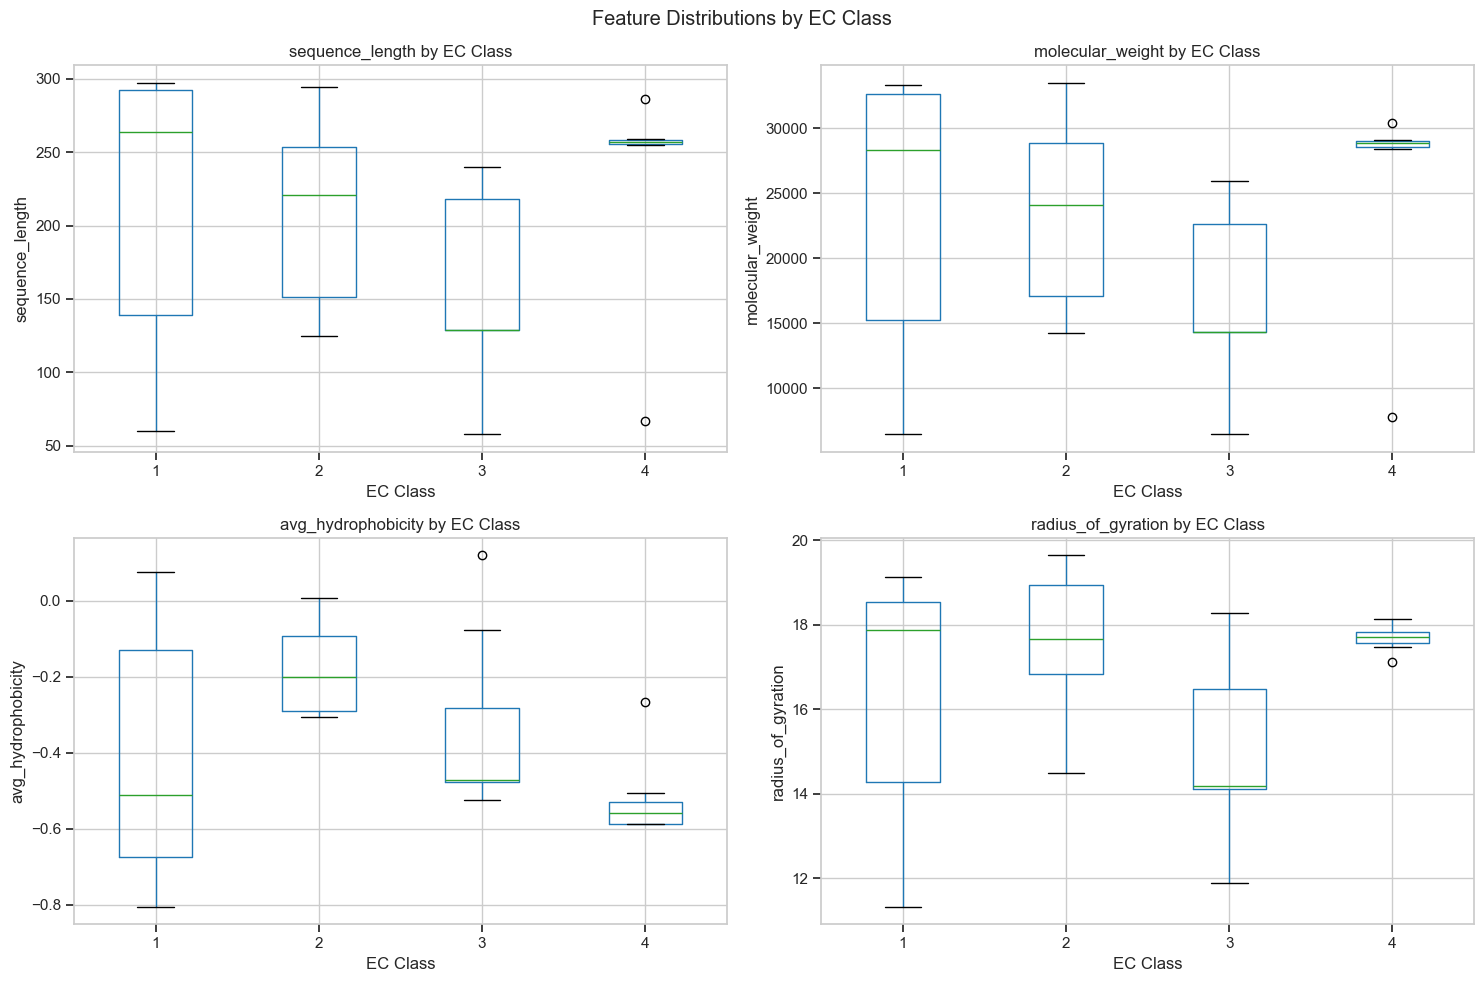


Top 10 features for class separation (F-score):
  26. coil_content        : F= 31.02, p=0.0000
  24. helix_content       : F= 24.73, p=0.0000
   4. aa_E                : F= 15.61, p=0.0000
   2. aa_C                : F= 14.59, p=0.0000
   7. aa_H                : F= 13.28, p=0.0000
  12. aa_N                : F= 13.16, p=0.0000
  28. negative_charge     : F= 12.92, p=0.0000
  10. aa_L                : F= 10.84, p=0.0001
  11. aa_M                : F= 10.22, p=0.0001
  38. estimated_helix_percent: F=  9.67, p=0.0001

✓ Feature analysis saved to ../data/processed/feature_importance.csv

📊 ANALYSIS SUMMARY:
✓ Feature extraction and analysis complete
✓ 43 features ready for ML
✓ 4 EC classes with good separation
✓ Ready to proceed to model training!


In [9]:
# Feature Analysis and Visualization
print("=== FEATURE ANALYSIS ===")

# Create feature correlation analysis
feature_df = pd.DataFrame(X, columns=feature_columns)

# 1. Top variable features
feature_variance = feature_df.var().sort_values(ascending=False)
print(f"Top 10 most variable features:")
for i, (feature, variance) in enumerate(feature_variance.head(10).items(), 1):
    print(f"  {i:2d}. {feature:20s}: {variance:.6f}")

# 2. Correlation heatmap for selected features
plt.figure(figsize=(12, 10))

# Select diverse features for correlation analysis
selected_features = [
    'sequence_length', 'molecular_weight', 'avg_hydrophobicity', 
    'total_atoms', 'radius_of_gyration', 'surface_residue_fraction',
    'positive_charge', 'negative_charge', 'aromatic_content', 'aa_A'
]

# Only use features that exist
existing_features = [f for f in selected_features if f in feature_columns]
corr_matrix = feature_df[existing_features].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix (Selected Features)')
plt.tight_layout()
plt.show()

# 3. Feature distribution by EC class
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

features_to_plot = ['sequence_length', 'molecular_weight', 'avg_hydrophobicity', 'radius_of_gyration']
features_to_plot = [f for f in features_to_plot if f in feature_columns]

for i, feature in enumerate(features_to_plot[:4]):
    if i < len(axes):
        # Create box plot by EC class
        df_plot = integrated_df[['ec_class', feature]]
        df_plot.boxplot(column=feature, by='ec_class', ax=axes[i])
        axes[i].set_title(f'{feature} by EC Class')
        axes[i].set_xlabel('EC Class')
        axes[i].set_ylabel(feature)

plt.suptitle('Feature Distributions by EC Class')
plt.tight_layout()
plt.show()

# 4. Feature importance preview (based on class separation)
from sklearn.feature_selection import f_classif
f_scores, p_values = f_classif(X, y)

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'f_score': f_scores,
    'p_value': p_values
}).sort_values('f_score', ascending=False)

print(f"\nTop 10 features for class separation (F-score):")
for i, row in feature_importance.head(10).iterrows():
    print(f"  {row.name+1:2d}. {row['feature']:20s}: F={row['f_score']:6.2f}, p={row['p_value']:.4f}")

# Save feature analysis
feature_importance.to_csv("../data/processed/feature_importance.csv", index=False)
print(f"\n✓ Feature analysis saved to ../data/processed/feature_importance.csv")

print(f"\n📊 ANALYSIS SUMMARY:")
print(f"✓ Feature extraction and analysis complete")
print(f"✓ {len(feature_columns)} features ready for ML")
print(f"✓ {len(set(y))} EC classes with good separation") 
print(f"✓ Ready to proceed to model training!")